# Backpropagation in depth

---

*You can watch a [video](https://youtu.be/RyKrG8rTGUY) of this lesson if you prefer.*

---

## What is Backpropagation?

At this point, we know how to build neural network architectures using components like [dense layers](../3-Dense_Networks/dense.ipynb),
[softmax](../4-Classification/classification.ipynb), and [recurrent layers](../5-RNN/rnn.ipynb).

Up until now, we've been loose with covering backpropagation. The neural network architecture itself was more be in focus.<br>
Understanding how Backprop works is important for tuning networks for performance, and achieving useful results in the first place.<br>
In this lesson, we'll do a deep dive into how backpropagation works.

> Backpropagation is how a neural network calculates how much to change each parameter in the network (the gradient).

We'll utilize a computational graph to keep track of which changes we make to input data.

In [24]:
import numpy as np
import sys
import os

sys.path.append(os.path.abspath("../data"))
from csv_data import SkyServerDatasetWrapper
from comp_graph.graph import Node, Parameter, display_chain

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Computational Graphs

A computational graph looks like this:

<div style="text-align:center;">
    <img src="../images/comp_graph/comp_graph.png" alt="Computational Graph">
</div>

In chronological order, this graph shows all the individual operations we performed (mostly multiplication, addition) to modify the value of input $X$.<br>
Keeping track of a operations in a computational graph enables us to realiably reverse our operations to do backpropagation.<br>
Actually, frameworks like PyTorch apply the same methodology to keep track of interrelations during forward and backward passes.

To create the computational graph, we'll make nothing less but a miniature version of PyTorch!

## Graphing the Softmax Function

Let's first build a computational graph of the softmax function, then backpropagate through that graph to get the gradient for our inputs.<br>
We introduced the softmax function in a [previous lesson](../4-Classification/classification.ipynb).<br>
Softmax is used to convert the output of a neural network into a probability distribution, e.g. for predictions like classification.

To recall, Softmax is defined as:
$$\zeta=\frac{e^{\hat{y_{i}}}}{\sum_{j=0}e^{\hat{y_{j}}}}$$

For each row of our neural network output, we raise $e$ to the power of our output value, then<br>
divide by the sum of $e$ raised to the power of each of the outputs for that row.

This is what softmax looks like in code:

In [2]:
def softmax_func(normalized):
    raised = np.exp(normalized)
    output = raised / np.sum(raised, axis=1).reshape(-1,1)
    return output

We can test softmax using some fake data:

In [3]:
# 5 rows, 3 columns, random numbers
x = np.random.rand(5, 3)

# Generate random correct labels for later
# >Exactly< one label per row is correct
y = np.zeros_like(x)
y[(np.arange(0,y.shape[0]), np.random.randint(0, 3, size=y.shape[0]))] = 1

The matrix $x$ is our input to the softmax function. It has $3$ columns/classes, $5$ rows/samples.<br>
The labels $y$ form our target. Each row is a one-hot encoded vector of $3$ entries each.<br>
The $1$ will correspond to the correct label for each row.<br>
We set $y$ (and $x$) randomly, but formally correctly, meaning each vector only ever contains one $1$ and two $0$s.

We can now go ahead and apply the softmax function:

In [4]:
normalized = x - np.max(x, axis=-1).reshape(-1,1)
print(softmax_func(normalized), "\n")
print('Output-wise summations:', np.sum(softmax_func(normalized), axis=1))

[[0.45362078 0.23360927 0.31276996]
 [0.3695646  0.29438625 0.33604914]
 [0.21821758 0.33880905 0.44297337]
 [0.36714924 0.29180974 0.34104102]
 [0.42520741 0.36985653 0.20493606]] 

Output-wise summations: [1. 1. 1. 1. 1.]


We subtract the maximum from each element in the row before passing the data into the softmax function.<br>
This prevents numerical overflow or underflow, because each [numeric type](https://numpy.org/doc/stable/user/basics.types.html) (float, integer, etc) can only hold a certain number of digits.<br>
When we raise $e$ to a very large or small number, we can generate a number that is too large to store in our specific data type.<br>
**Subtracting the max gives us the same end result, but reduces the risk of overflow or underflow.**

Feel free to try out softmax with and without subtracting the max to see how it works!

In [5]:
normalized = x - np.max(x, axis=-1).reshape(-1,1)
softmax_norml = softmax_func(normalized)
softmax_unrml = softmax_func(x)

print(softmax_norml, "\n")
print(softmax_unrml, "\n")
print('Output-wise summations:', np.sum(softmax_unrml, axis=1), "\n")

if np.allclose(softmax_norml, softmax_unrml) and False in (softmax_norml == softmax_unrml):
    print('The two softmaxes are close but not equal!')
    print('Cause for concern: Numerical instability.')


[[0.45362078 0.23360927 0.31276996]
 [0.3695646  0.29438625 0.33604914]
 [0.21821758 0.33880905 0.44297337]
 [0.36714924 0.29180974 0.34104102]
 [0.42520741 0.36985653 0.20493606]] 

[[0.45362078 0.23360927 0.31276996]
 [0.3695646  0.29438625 0.33604914]
 [0.21821758 0.33880905 0.44297337]
 [0.36714924 0.29180974 0.34104102]
 [0.42520741 0.36985653 0.20493606]] 

Output-wise summations: [1. 1. 1. 1. 1.] 

The two softmaxes are close but not equal!
Cause for concern: Numerical instability.


# Staged Softmax

Instead of computing the softmax derivative, we [previously](../4-Classification/classification.ipynb) used the fact that<br>
the derivative of the softmax and negative log likelihood functions "cancel out", and that we end up with a derivative of $p-y$.

But what if we want to find the uncancelled derivative ourselves?

We can approach this analytically, and find the derivative of the entire function.<br>
We can even use SymPy to help us do the derivation, like we did in an [earlier lesson](../4-Classification/classification.ipynb).<br>
Another method is to break the softmax function apart into individual operations.

Again, this is what softmax looks like:
$$\zeta=\frac{e^{\hat{y_{i}}}}{\sum_{j=0}e^{\hat{y_{j}}}}$$

Each operation will make a single modification to the data:

<div style="text-align:center;">
    <img src="../images/comp_graph/softmax_steps.svg" alt="Softmax Steps">
</div>

We perform $3$ operations on the data:
- $\text{Exp}$ - we raise $e$ to the power $x$.
- $\text{Sum}$ - we add up the $e^x$ values for each row.
- $\text{Divide}$ - we divide the $e^x$ values by the sums.

Note that the output of $\text{Exp}$ is passed to both the $\text{Sum}$ and $\text{Divide}$ operations.

By breaking up the softmax this way, we can take the derivative of each individual piece instead of the whole function at once.<br>
By applying the [chain rule](https://www.khanacademy.org/math/ap-calculus-ab/ab-differentiation-2-new/ab-3-1a/a/chain-rule-review), multiplying the derivative of each individual operation will result in the derivative of the whole function.<br>
We used the chain rule in previous lessons to find the partial derivative of the loss with respect to the model weights and biases.

Now we can build the forward pass of our staged softmax.<br>
The derivative of multiplication is easier to calculate than division, so we'll swap some of our operations to remove the division.<br>
Luckily for us, raising a value $x$ to the power $-1$ is the same as taking $\frac{1}{x}$.<br>
Instead of dividing $\frac{\text{Exp}}{\text{Sum}}$, we can do $\text{Exp}*\text{Sum}^{-1}$.

The change in notation leaves us with these operations:
- $\text{Exp}$
- $\text{Sum}$
- $\text{Pow}$ - we invert the sum by raising to the power $-1$
- $\text{Multiply}$ - we multiply the inverted sum and the exp values

In [6]:
# Softmax, explicitly in stages
raised = np.exp(normalized)
summed = np.sum(raised, axis=-1).reshape(-1,1) # Reshape so each row has 1 column.
pow = summed ** -1
staged_softmax = raised * pow

print(staged_softmax)

[[0.45362078 0.23360927 0.31276996]
 [0.3695646  0.29438625 0.33604914]
 [0.21821758 0.33880905 0.44297337]
 [0.36714924 0.29180974 0.34104102]
 [0.42520741 0.36985653 0.20493606]]


Our staged softmax has the same output as our original, normalized function.

# Softmax Derivative

To get the softmax derivative, we need to progrss through the operations we did before, but backwards:

<div style="text-align:center;">
    <img src="../images/comp_graph/softmax_steps_full_bwd.svg" alt="Softmax Steps Full">
</div>

To calculate the loss of our softmaxed output, we will use the negative log likelihood.<br>
The negative log likelihood is $NLL = -\sum_{i=0} y_{i} \log p_{i}$.

$y$ is only non-zero at a single position per row.<br>
This means, we will only have a single-valued $NLL$ result (the $-y_{i} * \log p_{i}$ where $i$ is the correct label at $y=1$).

We can solve this derivative by breaking $NLL$ into two steps:
- $\log p_{i}$ - the derivative of $\text{log}_e(p_{i})$ is $\frac{1}{p_{i}}$
- $-y_{i} * \log p_{i}$ - the derivative w.r.t $\log p_{i}$ is $(-y_{i})$

So the derivative of $NLL$ is $\frac{1}{p_{i}} * (-y_{i}) = \frac{-y_{i}}{p_{i}}$.<br>
We'll use this negative log likelihood derivative $\frac{\partial L}{\partial p}$ below:

In [7]:
nll_grad = lambda y, pred: -1 * y / pred

loss_grad = nll_grad(y, staged_softmax)
print(loss_grad)

[[-2.20448456 -0.         -0.        ]
 [-2.70588685 -0.         -0.        ]
 [-4.5825822  -0.         -0.        ]
 [-2.72368804 -0.         -0.        ]
 [-2.35179343 -0.         -0.        ]]


We can now calculate the softmax derivative by multiplying the $NLL$'s derivatives of the individual operations.

- $\text{Exp}$ - the derivative of $e^x$ is $e^x$
- $\text{Sum}$ - as a sum operation will combine input elements into one, we just distribute the gradient over all input elements. A change to any of the input elements will have a direct impact on the output.
- $\text{Pow}$ - the derivative of $x^{-1}$ is $-1 * x^{-2}$. More on this [here](https://www.khanacademy.org/math/old-ap-calculus-ab/ab-derivative-rules/ab-diff-negative-fraction-powers/a/power-rule-review).
- $\text{Multiply}$ - the derivatives of $x*y$ are $y$ wrt $x$ and $x$ wrt $y$.  This is because any change to $x$ is multiplied by $y$, and vice versa. Thus the rate of change of $x$ is $y$, and vice versa.

Let's build up the backward pass of our staged softmax. The backward pass will start with the loss gradient.<br>
This will be a matrix showing how much we need to adjust each of the output values from our softmax to reduce our loss.<br>
We can then compute gradients for each operation, ending with the gradient against the input, $x$.<br>
If $x$ was the output of a neural network, we would continue backpropagation at that point to adjust the network parameters.

We'll name each gradient according to the step it is a gradient for, not the step it is coming from.<br>
So `raised_grad` is the gradient on `raised`.

In [8]:
# Backpropagation through the softmax

# Step 4
# staged_softmax = raised * pow -> pow is partial derivative for raised, concat with loss_grad
raised_grad = loss_grad * pow
pow_grad = loss_grad * raised
pow_grad = np.sum(pow_grad, axis=-1).reshape(-1,1) # reshape gradient to match input data

# Step 3
# pow = summed ** -1 -> derivative of summed is -1 * summed ** -2, concat with pow_grad
summed_grad = (-1 * summed ** -2) * pow_grad

# Step 2
# raised = np.exp(normalized) -> exp is applied to each element individually
raised_grad_2 = np.ones_like(raised) * summed_grad # concat + distribute gradient across inputs

# Step 1
# summed = np.sum(raised, axis=-1).reshape(-1,1) -> Add up all the raised values
raised_grad += raised_grad_2 # sum incoming gradients
# Finally, concatenate raised_grad with the derivative of exp(normalized)
staged_softmax_grad = raised_grad * np.exp(normalized)

We did two things above that might seem confusing.

The first is that we summed $2$ gradients on `raised`.<br>
This is because `raised` connects to $2$ operations, and both have separate gradients.<br>
**Whenever this happens, we sum the gradients.**

The second is that we reshaped `pow_grad` to have a single column.<br>
This is to match `pow`, which only had `1` column in the forward pass.<br>
**Whenever a gradient doesn't match the shape of the input data, we change the size of the gradient to match it.**<br>
This is because the gradient represents the partial derivative against the input data to the operation.



We can compare our result to the derivative of the softmax equation to make sure everything worked.<br>
The derivative of the softmax is $S_{i}((i==j) - S_{j})$.  We take each element of a single row in the output of a softmax, like this:

    [0.28, 0.25, 0.47]

We then compare each element against each other element. So we could start at element $0$ ($.28$), and compare it to itself.<br>
Then $i$ is $0$ and $j$ is $0$. So the equation is $.28 * (1 - .28)$.  When we then keep $i$ the same, but move $j$ to $1$.<br>
The equation becomes $.28 * (0 - .25)$.  

And so on, until we construct a matrix like this:

<div style="text-align:center;">
    <img src="../images/comp_graph/softmax_deriv.svg" alt="Softmax Derivative">
</div>

We then sum across the rows and multiply by the incoming gradient to get the partial derivative against the inputs.<br>
We can define the softmax derivative in code:

In [9]:
def softmax_grad_func(softmax, loss_grad):
    output = np.zeros_like(softmax)
    for i in range(softmax.shape[0]):
        sm_row = softmax[i,:]
        sm_grad = (-np.outer(sm_row, sm_row) + np.diag(sm_row.flatten()))
        row_grad = sm_grad * loss_grad[i,:].reshape(1,-1)
        output[i,:] = np.sum(row_grad, -1)
    return output

We then compare our derivative by stages with the derivation.<br>
The `np.allclose` function tells us if all the values in an array are close to another array.<br>
We use this instead of `==` because there are small numerical differences in similar computations with numpy.

In [10]:
derived_softmax_grad = softmax_grad_func(staged_softmax, loss_grad)
np.allclose(derived_softmax_grad, staged_softmax_grad)

True

We can also compare the gradient we computed of the loss and softmax together with the derivative of both together, which is $p-y$:

In [11]:
np.allclose(staged_softmax_grad, staged_softmax - y)

True

# Operations

Breaking softmax into stages helped greatly in understanding the basic units of a computational graph.<br>
But what if we don't want to have to type out all the code for the forward and backward pass every time?

It would be nice if we could only define the forward pass, and automatically have the backward pass happen. The solution would be an autograd engine. Frameworks like PyTorch provide exactly that.

We can build our own version of PyTorch by individually defining each operation, then mixing and matching the operations to create a more complex equation.<br>
By doing this, we can create a computational graph like this one:

<div style="text-align:center;">
    <img src="../images/comp_graph/comp_graph.png" alt="Computational Graph">
</div>

Each node in the graph will be a separate class that knows how to do a forward and backward pass.<br>
So, we can just execute the graph to run forward and backward passes.

We can start out by defining the operations.<br>
I've written a class called `Node`, which we can subclass to define each operation. You can look at the code for `Node` if you want.<br>
It gives us some nice methods for running the operations in a graph in order, both forward and backward:

- `apply_fwd` - runs the forward pass up to the node it is called on.
- `apply_bwd` - runs the backward pass from the node it is called on backwards.
- `zero_grad` - zero out our gradient before running a backward pass.
- `generate_graph` - helps us visualize the computational graph.
- `generate_derivative_chains` - shows us the equation for calculating the partial derivative at a node.

For each operation, we just implement the `forward` and `backward` methods, which take in input data, and pass them through the operation.<br>
**The `Node` class from there on takes care of the rest.**

We'll use the same formulas for each operation that we used in our staged softmax earlier:

In [12]:
class Exp(Node):
    def forward(self, x):
        return np.exp(x) # raise e to the power x

    def backward(self, grad):
        x = self.cache[0] # Pull the x value used in the forward pass
        return np.exp(x) * grad # multiply the incoming gradient by the derivative

class Sum(Node):
    def forward(self, x):
        return np.sum(x, axis=-1).reshape(-1,1)

    def backward(self, grad):
        x = self.cache[0] # Pull the x value used in the forward pass
        return np.ones_like(x) * grad # distribute the gradient over the input data shape

class Pow(Node):
    def forward(self, x, exponent):
        return x ** exponent

    def backward(self, grad):
        x, exponent = self.cache # Pull the x and exponent values used in the forward pass
        return grad * exponent * x ** (exponent - 1), 1

class Multiply(Node):
    def forward(self, x, y):
        return x * y

    def backward(self, grad):
        x, y = self.cache # Pull the x and y values used in the forward pass
        return grad * y, grad * x

As you can see above, we've defined the $4$ operations that we need for our softmax in code.<br>
We can now define our whole softmax operation as a computational graph.<br>
When we initialize a `Node`, we pass in the nodes that feed into it.

If we're using the node to feed in data (like inputs), we use a special `Parameter` node:

In [13]:
# The input data for our network.  We set needs_grad=True so the gradient is calculated for this parameter in the backward pass.
# Desc is a short description of what the data in this node is.
X = Parameter(x, desc="X", needs_grad=True)

# Raise e to the power x.  Out is a description of the output of the node.
raised = Exp(X, out="e^X")
# Sum the raised values.
summed = Sum(raised, out="sum(e^X)")

# Define -1 as a parameter, so we can use it as an exponent.
negative_one = Parameter(-1, desc="-1", needs_grad=False)
# Invert our sums
inverted = Pow(summed, negative_one, out="1 / sum(e^X)")
# Multiply the inverted sums by e^X
softmax = Multiply(raised, inverted, out="softmax(X)")

We can now use the `generate_graph` method on the `softmax` node to visualize the computational graph.

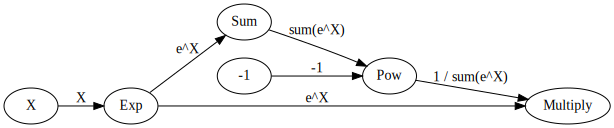

In [15]:
softmax.generate_graph()

And use the `apply_fwd` method to calculate the softmax.<br>
We can then verify that it is the same as our `staged_softmax` that we calculated earlier:

In [16]:
operations_softmax = softmax.apply_fwd()
np.allclose(staged_softmax, operations_softmax)

True

**Now, for the cool part.**<br>
We can use the same computational graph to do the backward pass!

Let's first visualize what the backward pass looks like:

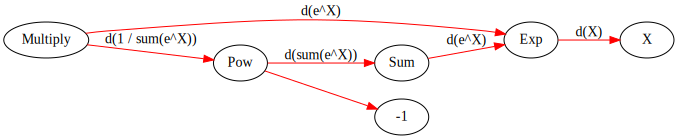

In [17]:
softmax.generate_graph(backward=True)

We can then run `apply_bwd` to run the backward pass.<br>
We first call `zero_grad` to ensure that the initial gradients on all nodes are properly set to zero.

Any parameter nodes with `needs_grad` set to `True` will now have a property called `grad`, where we can get the gradient.<br>
We can get the gradient from `X`, and verify that it matches our staged gradient.

In [18]:
softmax.zero_grad()
softmax.apply_bwd(loss_grad)

operations_softmax_grad = X.grad
np.allclose(staged_softmax_grad, operations_softmax_grad)

True

As a bonus, we can also check the equations that we multiplied to calculate the partial derivative with respect to `X`.

You can see that we had to add together 2 different gradients, just like we did with the staged version.<br>
The $\partial$ symbol means partial derivative, and $\frac{\partial e^{X}}{\partial X}$ means "the partial derivative of $e^X$ with respect to $X$.<br>
The way to interpret this partial derivative is "as $X$ changes, how does $e^{X}$ change?".<br>
By multiplying the partial derivatives of each operation, we can get the larger partial derivative, which is $\frac{\partial L}{\partial X}$ - how the loss changes as we change $X$.

In [19]:
softmax.generate_derivative_chains()
display_chain(X.display_partial_derivative())

<IPython.core.display.Latex object>

We just built a computational graph of the softmax function, then ran a forward and backward pass.<br>
This is exactly how deep learning frameworks like PyTorch and TensorFlow work.<br>
They define common operators, like `torch.dot`, keep track of what operators you called, build a graph,<br>
and automatically run the backward pass based on the derivative of each operator.<br>
You could say we built a miniature deep learning framework!

## 2-Layer Network

Let's extend our framework to work across a 2-Layer neural network.<br>
We need to define 3 additional operations:

- `MatMul` - to multiply two matrices. The forward pass is `x@w`.
- `Add` - add two values up.
- `Relu` - a nonlinear activation function. Anything below $0$ will be set to $0$.

Here are the operations:

In [20]:
class MatMul(Node):
    def forward(self, x, w):
        return x @ w # multiply the two matrices.

    def backward(self, grad):
        x, w = self.cache
        # return the input gradient times the weights as the gradient on x
        # the input x values (from the forward pass) times the input gradient is the gradient on the weights
        return grad @ w.T, x.T @ grad


class Add(Node):
    def forward(self, x, b):
        return x + b

    def backward(self, grad):
        # Any change to x or b will scale the output the same amount
        return grad, grad


class Relu(Node):
    def forward(self, x):
        return np.maximum(x, 0)

    def backward(self, grad):
        x = self.cache[0]
        new_grad = np.array(grad)
        # The derivative of relu is 0 when the input
        # in the forward pass was below 0
        # 1 otherwise
        new_grad[x < 0] = 0
        return new_grad

When you train a neural network using a framework like PyTorch, you will usually be using the GPU.<br>
GPUs enable us to parallelize operations and train neural networks much faster than we could with a CPU.

One way to speed up GPU code is to fuse operators.<br>
This means that we combine operators that run together into a single operator.<br>
This combined operator can then be optimized into a kernel that runs better on the GPU.<br>
We'll discuss this more in a future lesson.

As an example of the process, below you can see the fusion of the `Softmax` operation.<br>
The fused softmax used the softmax functions we defined before to do the forward and backward passes.

We also fuse an entire neural network layer into the `Dense` operator.

In [21]:
class Softmax(Node):
    def forward(self, x):
        return softmax_func(x)

    def backward(self, grad):
        x = self.cache[0]
        softmax = self.forward(x)
        return softmax_grad_func(softmax, grad)

class Dense(Node):
    def forward(self, x, w, b):
        # Multiply by weight, add bias
        return x @ w + b

    def backward(self, grad):
        x, w, b = self.cache
        # Return 3 gradients for x, w, and b
        return grad @ w.T, x.T @ grad, grad

We now have the operators we need to define our neural network. Let's first load in the data.<br>
We'll use the same telescope data from an earlier lesson.<br>
We have observations from a telescope, and we want to classify whether each observation is a star, galaxy, or quasar.

We use a data wrapper that I wrote to load and split the data automatically.<br>
We'll only use the training set in this lesson, but you can experiment with the other $2$ sets as well.

In [26]:
# Load the data
wrapper = SkyServerDatasetWrapper()
[train_x, train_y], [valid_x, valid_y], [test_x, test_y] = wrapper.get_flat_datasets()

print(train_x[:2])

[[ 0.16745842 -0.58492272  1.03148637 -0.34855938 -0.83728027 -0.94605772
  -0.99534154 -0.83806089  0.21085172 -0.21763043 -0.36973112  1.03148936
   1.30931064]
 [ 0.16886159 -0.58311429  0.05243046 -0.16653251 -0.15415531 -0.08264457
  -0.02604308 -0.83806089  0.21085172 -0.21763043 -0.36984929 -0.63621258
  -0.87919741]]


We then need to one-hot encode our data so that we can use it for classification.<br>
We create $3$-element vectors where only one element is $1$, and the others are $0$.<br>
The position of the $1$ corresponds to the target we want to predict.

In [94]:
def encode(target, max_value=3):
    # A matrix with 3 columns
    encoded = np.zeros((target.shape[0], max_value))
    # Setup the indices that we'll set to one
    inds = target.astype(int)
    # Set the target positions to 1
    encoded[inds] = 1
    return encoded

train_y = encode(train_y)

Now that we have our training data, we can initialize our weights and biases.<br>
We're taking in $13$ features, so we'll setup our weights for the first layer accordingly.<br>
We want to output $3$ digits, one for each encoding position.

In [95]:
# Set a seed so we can reproduce results
np.random.seed(0)

w1 = np.random.rand(13, 10)
b1 = np.random.rand(1, 10)
w2 = np.random.rand(10, 3)
b2 = np.random.rand(1, 3)

We can now define our network in code!<br>
This is very similar to networks we've built in the past.<br>
We have our first layer, with a ReLU activation, then our second layer, then Softmax to get probabilities:

In [96]:
X = Parameter(train_x, desc="X", needs_grad=False)
Y = Parameter(train_y, desc="y", needs_grad=False)

w1_param = Parameter(w1, desc="W1")
b1_param = Parameter(b1, desc="b1")

matmul1 = MatMul(X, w1_param, out="X @ W1")
add1 = Add(matmul1, b1_param, out="Z1")

layer1 = Relu(add1, out="A1")

w2_param = Parameter(w2, desc="W2")
b2_param = Parameter(b2, desc="b2")
matmul2 = MatMul(layer1, w2_param, out="Z1 @ W2")
add2 = Add(matmul2, b2_param, out="Z2")

softmax = Softmax(add2, out="softmax(Z2)")

Just like before, we can create a computation graph.  This one is more complex than before, but should still be readable!

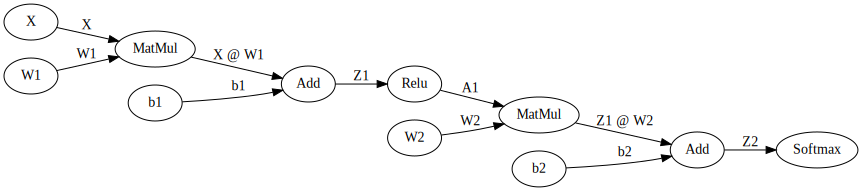

In [97]:
softmax.generate_graph()

We can create predictions using `apply_fwd`:

In [98]:
predictions = softmax.apply_fwd()

predictions[:2]

array([[0.51408579, 0.29557176, 0.19034245],
       [0.42508635, 0.26655849, 0.30835516]])

Now, we can run the backward pass of the network.  We'll first graph it out:

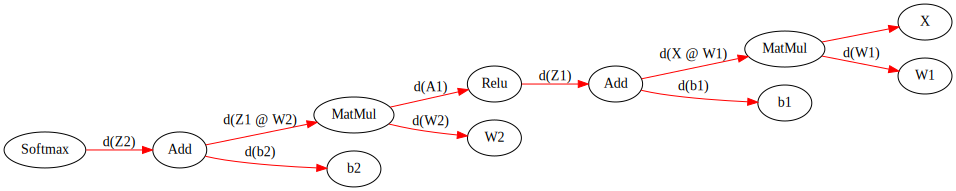

In [99]:
softmax.generate_graph(backward=True)

Then we'll run our backward pass.<br>
We first calculate our loss gradient, then pass it into our backward pass as the incoming gradient:

In [100]:
softmax.zero_grad() # zero out the gradients
loss_grad = nll_grad(train_y, predictions) # compute the loss gradient
softmax.apply_bwd(loss_grad) # pass the loss gradient into the softmax, and run the backward pass
softmax.generate_derivative_chains() # generate our derivative equations

Each of our parameters should now have a gradient.  We'll only show `w2`, but you can look at the other parameters as well:

In [101]:
w2_param.grad[:5]

array([[ 0.27379929, -0.05720028, -0.21659901],
       [ 0.47819796, -0.09990186, -0.3782961 ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.24295538, -0.05075658, -0.1921988 ],
       [ 0.27254325, -0.05693788, -0.21560538]])

We can also look at the partial derivative chains to see how we calculate the derivative with respect to a specific parameter:

In [102]:
display_chain(w2_param.display_partial_derivative())

<IPython.core.display.Latex object>

In [103]:
display_chain(w1_param.display_partial_derivative())

<IPython.core.display.Latex object>

We just built a computational graph, and used it to do the full forward and backward pass for a neural network!<br>
If you want, you can extend this to update the parameters and train the network.<br>
You would just need to set a learning rate, then subtract the gradient from each parameter.<br>
You would have to set a batch size, and iterate through the data as well.

This has hopefully given you a good look at how backpropagation, works, and how we compute the partial derivatives of each operation, then multiply them out.

Let's do a quick verification to make sure that we did everything correctly.<br>
We can implement the network forward and backward pass like we did in an earlier lesson:

In [104]:
# Forward pass
l1 = train_x @ w1 + b1
l1_activated = np.maximum(l1, 0)
l2 = l1_activated @ w2 + b2
probs = softmax_func(l2)

# Loss
loss_grad = nll_grad(train_y, probs)

# L2 gradients
sm_grad = softmax_grad_func(probs, loss_grad)
l2_w_grad = l1_activated.T @ sm_grad
l2_b_grad = sm_grad.sum(axis=0)

# L1 gradients
l1_grad = sm_grad @ w2.T
l1_grad[l1 < 0] = 0
l1_w_grad = train_x.T @ l1_grad
l1_b_grad = l1_grad.sum(axis=0)

Then we can verify that our computational graph matches the manual results:

In [105]:
np.allclose(l1_w_grad, w1_param.grad)

True

# Wrap-up

We did **a lot** in this lesson!<br>
We learned how to break apart a derivative into steps, then compute each step separately.<br>
Then, we constructed a computational graph and ran the forward and backward passes.

I recommend doing some experimentation with the graph, and making sure you *really* understand how everything is working.<br>
In the next lesson, we'll use PyTorch to automatically construct the graph for us.